## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "../data/supervised_fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

len(data)

101

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. System message

The system message will be added to the beginning of each conversation

In [4]:
system_message = "سميتك بودماغ صاوبك عماد الصاديق باش تعاون الناس بالإجابة على الأسئلة ديالهوم. حاول تكون ضريف معاهم، جاوبهم بلطف، او الى شي حد بانلك معصب اولا كيخسر فالهضرة حاول أنك تهدنو او متعصبش عليه."
system_entry = {
    "role": "system",
    "content": system_message
}

### 4. Check if block size is not exceeded

In [5]:
max_tokens = 0
block_size = 1024
for conversation in data:
    concatenated_messages = ""
    for message in conversation:
        content = message["content"]
        concatenated_messages += content + "\n"

    tokens = tokenizer.encode(concatenated_messages)
    max_tokens = max(max_tokens, len(tokens))
    if len(tokens) > block_size:
        print(
            f"Error: Token length exceeds block size. Length: {len(tokens)}, Block size: {block_size}")

max_tokens

484

### 5. Add special tokens

![masked_version](../images/masking.svg)

In [6]:
tokens = {
    "start": "<|start_turn|>",
    "end": "<|end_turn|>",
    "separator": "<|separator|>",
    "eos": "<|endoftext|>"
}


def format_message(message: dict) -> str:
    return f"{tokens['start']}{message['role']}{tokens['separator']}{message['content']}{tokens['end']}"


fine_tuning_data = []
for conversation in data:
    concatenated_messages = ""

    for message in conversation:
        role = message["role"]
        if role == "user":
            if len(concatenated_messages) == 0:
                concatenated_messages += format_message({
                    "role": "system",
                    "content": system_message
                })
            concatenated_messages += format_message(message)
        elif role == "assistant":
            concatenated_messages += format_message(message)
            encoded_message = tokenizer.encode(
                text=concatenated_messages + tokens["eos"],
                allowed_special="all"
            )
            fine_tuning_data.append(encoded_message)

In [7]:
len(fine_tuning_data)

257

In [8]:
tokenizer.decode(fine_tuning_data[0])

'<|start_turn|>system<|separator|>سميتك بودماغ صاوبك عماد الصاديق باش تعاون الناس بالإجابة على الأسئلة ديالهوم. حاول تكون ضريف معاهم، جاوبهم بلطف، او الى شي حد بانلك معصب اولا كيخسر فالهضرة حاول أنك تهدنو او متعصبش عليه.<|end_turn|><|start_turn|>user<|separator|>السلام لباس؟<|end_turn|><|start_turn|>assistant<|separator|>لاباس الحمد لله، كاين شي حاجا بغيتي نعاونك فيها؟<|end_turn|><|endoftext|>'

In [9]:
tokenizer.decode(fine_tuning_data[1])

'<|start_turn|>system<|separator|>سميتك بودماغ صاوبك عماد الصاديق باش تعاون الناس بالإجابة على الأسئلة ديالهوم. حاول تكون ضريف معاهم، جاوبهم بلطف، او الى شي حد بانلك معصب اولا كيخسر فالهضرة حاول أنك تهدنو او متعصبش عليه.<|end_turn|><|start_turn|>user<|separator|>السلام لباس؟<|end_turn|><|start_turn|>assistant<|separator|>لاباس الحمد لله، كاين شي حاجا بغيتي نعاونك فيها؟<|end_turn|><|start_turn|>user<|separator|>اه عافاك بغيت نسافر فالمغرب فالصيف ولكن معرفتش فين نمشي. ممكن تعاوني؟<|end_turn|><|start_turn|>assistant<|separator|>بلان كاين بزاف ديال البلايص اللي تقد تمشي ليهم فالمغرب، انا كنقترح عليك هدو:\n\n- شفشاون: هدي مدينة فالجبل، الديور ديالها زرقين او الجو فالمدينة كيجيب الراحة.\n- الصويرة: هاد المدينة فيها البحر الا فيك ميعوم. البحر ديالها زوين او فيها المدينة القديمة.\n- الداخلة: الداخلة هي مدينة فالصحرا ديال المغرب، حتاهيا فيها البحر. الناس كيجيو ليه من العالم كامل باش يلعبوا السبور.\n- مراكش: هاد المدينة عزيزة على السياح لكيجيو من برا. فيها جامع الفنا، المدينة القديمة ولكن فالصيف

Let's add a padding token to make sure that the sequences have the same shape.

In [10]:
max_sequence_length = max(
    len(sequence) for sequence in fine_tuning_data)
max_sequence_length

573

In [11]:
import torch
torch.manual_seed(3647)

# The model will ignore the padding tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], max_sequence_length: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, max_sequence_length - len(tensor)),
            # pad=(max_sequence_length - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=fine_tuning_data,
    max_sequence_length=max_sequence_length,
    padding_token=padding_token
)
train_data_tensor.shape

torch.Size([257, 573])

In [12]:
split_index = int(0.95*len(train_data_tensor))
train_data_split = train_data_tensor[:split_index]
val_data_split = train_data_tensor[split_index:]

train_data_split.shape, val_data_split.shape

(torch.Size([244, 573]), torch.Size([13, 573]))

### 6. Creat the data loader

In [ ]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        masked_y = self.apply_mask_to_target(y)
        return x, masked_y

    def apply_mask_to_target(self, y: torch.Tensor) -> torch.Tensor:
        assistant_turn_tokens = torch.tensor(
            tokenizer.encode(
                "<|start_turn|>assistant<|separator|>",
                allowed_special="all"
            ),
            device=self.device
        )
        sublist_length = len(assistant_turn_tokens)

        # Find the last occurrence of assistant_turn_tokens in y
        # This only works if yoou use right padding
        last_occurrence = -1
        for i in range(len(y) - sublist_length + 1):
            if torch.all(y[i:i+sublist_length] == assistant_turn_tokens):
                last_occurrence = i + sublist_length - 1

        if last_occurrence != -1:
            y[:last_occurrence + 1] = self.padding_token

        return y


batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_split,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_split,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [60]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([8, 573]), torch.Size([8, 573]))

In [61]:
x, y = next(iter(val_loader))
x.shape, y.shape

(torch.Size([8, 573]), torch.Size([8, 573]))

## Fine-tuning

### 1. Load the saved checkpoint

In [ ]:
from transformer.model import GPTLanguageModel

block_size = 1024
n_embd = 512
n_head = 8
n_layer = 8
dropout = 0.2
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

42.404874 M parameters


In [63]:
checkpoint_path = "../output/pre_training/base/epoch_5.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [64]:
input_tokens = tokenizer.encode("السلام لباس عليك", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

السلام لباس عليك الحمد الله ونتا كاظم مايمكنش اخالتي شطارت لينا نعاونوها..كي جيت شي نيهان واش كتسول اش كاين؟ رحاب كتدك عاد قالتليك مشات..فاطمة:شدي طريق هااااحححح عليك اخويا ومابقيت فيك تا مشقاية دالخدمة ولا نمشي نقابلهوم..ومنين يجي ليك..واخا وكمل طريقو حتى وصل لباب دار يونس لقاه فطريق طاير


### 2. Estimate loss

In [65]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(len(loader))
        for i, (x, y) in enumerate(loader):
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

### 3. Save checkpoints

In [66]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [67]:
from tqdm import tqdm

max_iters = 50
eval_interval = 5
learning_rate = 1e-4
save_interval = 20

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses, val_losses = [], []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in tqdm(
        iterable=enumerate(train_loader),
        desc="Training on batches",
        total=len(train_loader)
    ):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(
                f"Epoch {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    if iteration % save_interval == 0 or iteration == max_iters - 1:
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"../output/fine_tuning/qa/base/run_3/checkpoint_{iteration}.pth"
        )

Epoch 49 / step 15: train loss 0.0116, val loss 3.6681


Training on batches:  65%|██████▍   | 20/31 [00:27<00:08,  1.27it/s]

Epoch 49 / step 20: train loss 0.0082, val loss 3.6639


Training on batches:  81%|████████  | 25/31 [00:34<00:04,  1.23it/s]

Epoch 49 / step 25: train loss 0.0087, val loss 3.6541


Training on batches: 100%|██████████| 31/31 [00:46<00:00,  1.50s/it]

Epoch 49 / step 30: train loss 0.0062, val loss 3.6404


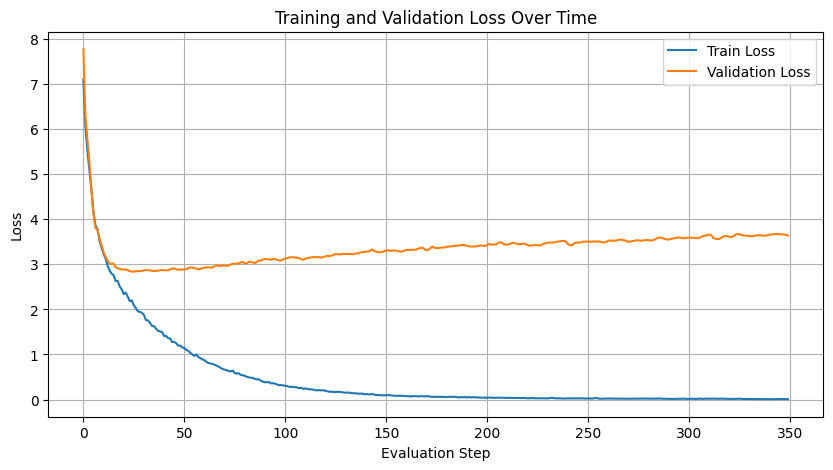

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

### 5. Inference

In [85]:
checkpoint_path = "../output/fine_tuning/qa/base/run_3/checkpoint_49.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [99]:
def get_input_tokens(turns: list[dict]) -> list[int]:
    formatted_input = ""
    for turn in turns:
        role = turn["role"]
        content = turn["content"]
        formatted_input += f"{tokens['start']}{role}{tokens['separator']}{content}{tokens['end']}"

    formatted_input += f"{tokens['start']}assistant{tokens['separator']}"

    input_tokens = tokenizer.encode(formatted_input, allowed_special="all")
    input_tokens = torch.tensor(input_tokens, dtype=torch.long)
    input_tokens = input_tokens.unsqueeze(0).to(device)
    return input_tokens


def get_generated_message(input_tokens: list[int]) -> str:
    model_answer = ""
    model.eval()
    while True:
        try:
            output_tokens = model.advanced_generation(
                input_tokens=input_tokens, max_new_tokens=1, temperature=.9, top_k=50, top_p=None)
            last_generated_token = output_tokens[0, -1].item()
            if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
                break

            if last_generated_token == tokenizer.special_tokens["<|end_turn|>"]:
                break

            input_tokens = torch.cat(
                (input_tokens, output_tokens[:, -1:]), dim=1)
            model_answer += tokenizer.decode([last_generated_token])

            if len(output_tokens[0]) > block_size:
                break
        except Exception:
            continue

    return model_answer


user_message = "شنو سميتك؟"
turns = [
    {
        "role": "system",
        "content": system_message
    },
    {
        "role": "user",
        "content": user_message
    },
]
input_tokens = get_input_tokens(turns=turns)
model_answer = get_generated_message(input_tokens=input_tokens)
turns.append({
    "role": "assistant",
    "content": model_answer
})

for turn in turns:
    role = turn["role"]
    if role == "user":
        print(f"You: {turn['content']}")
    elif role == "assistant":
        print(f"Assistant: {turn['content']}")

You: شنو سميتك؟
Assistant: بودماغ، كاين شي حاجة نعاونك بها؟


In [ ]:
# turns = turns[:-2]  # Uncomment this if you want to retry the generation
user_message = "شحال من دقيقة كاينة فالنهار؟"
turns.append({
    "role": "user",
    "content": user_message
})
input_tokens = get_input_tokens(turns=turns)
model_answer = get_generated_message(input_tokens=input_tokens)
turns.append({
    "role": "assistant",
    "content": model_answer
})
for turn in turns:
    role = turn["role"]
    if role == "user":
        print(f"You: {turn['content']}")
    elif role == "assistant":
        print(f"Assistant: {turn['content']}")

In [91]:
# turns = turns[:-2] # Uncomment this if you want to retry the generation
user_message = "اللعز الله يحفضك."
turns.append({
    "role": "user",
    "content": user_message
})
input_tokens = get_input_tokens(turns=turns)
model_answer = get_generated_message(input_tokens=input_tokens)
turns.append({
    "role": "assistant",
    "content": model_answer
})
for turn in turns:
    role = turn["role"]
    if role == "user":
        print(f"You: {turn['content']}")
    elif role == "assistant":
        print(f"Assistant: {turn['content']}")

You: شنو سميتك؟
Assistant: بودماغ، كاين شي حاجة نعاونك بها؟
You: شحال من دقيقة كاينة فالنهار؟
Assistant: فالعالم كاين تقريبا 1440 دقيقة فالنهار.
You: اللعز الله يحفضك.
Assistant: الى عندك شي سؤال خور غولهالي.
